In [1]:
using Pkg
Pkg.activate("../../Project.toml")

include("../../LogLoss/RealRealHighDimension.jl")
include("../ForecastingMainNew.jl");
using JLD2
using DataFrames
using StatProfilerHTML
using BenchmarkTools

  Activating project at `~/Documents/QML Project/QuantumInspiredML`


# ECG200

In [5]:
svpath = "../../Data/ecg200/mps_saves/legendreNN2_d8_chi35.jld2"
svpath_ns = "../../Data/ecg200/mps_saves/legendreNN2_ns_d8_chi35.jld2"
dloc =  "../../Data/ecg200/datasets/ecg200.jld2"



f = jldopen(dloc, "r")
    X_train = read(f, "X_train")
    y_train = read(f, "y_train")
    X_test = read(f, "X_test")
    y_test = read(f, "y_test")
close(f)



f = jldopen(svpath, "r")
    mps = read(f, "mps")
    # opts = read(f, "opts")
close(f)
setprecision(BigFloat, 128)
Rdtype = Float64

verbosity = 0
test_run = false
track_cost = false
#

project = false
encoding = legendre(norm=false, project=project)
encode_classes_separately = false
train_classes_separately = false

#encoding = Basis("Legendre")
dtype = encoding.iscomplex ? ComplexF64 : Float64

opts=Options(; nsweeps=20, chi_max=35,  update_iters=1, verbosity=verbosity, dtype=dtype, loss_grad=loss_grad_KLD,
bbopt=BBOpt("CustomGD"), track_cost=track_cost, eta=0.0025, rescale = (false, true), d=8, aux_basis_dim=2, encoding=encoding, 
encode_classes_separately=encode_classes_separately, train_classes_separately=train_classes_separately, exit_early=false, sigmoid_transform=true)

fc = load_forecasting_info_variables(mps, X_train, y_train, X_test, y_test, opts);


f = jldopen(svpath_ns, "r")
    mps_ns = read(f, "mps")
    # opts_ns = read(f, "opts")
close(f)

opts_ns=Options(; nsweeps=20, chi_max=35,  update_iters=1, verbosity=verbosity, dtype=dtype, loss_grad=loss_grad_KLD,
bbopt=BBOpt("CustomGD"), track_cost=track_cost, eta=0.0025, rescale = (false, true), d=8, aux_basis_dim=2, encoding=encoding, 
encode_classes_separately=encode_classes_separately, train_classes_separately=train_classes_separately, exit_early=false, sigmoid_transform=false)

fc_ns = load_forecasting_info_variables(mps_ns, X_train, y_train, X_test, y_test, opts_ns);

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 8, chi_max = 35

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 8, chi_max = 35

 Created 2 forecastable struct(s) containing class-wise mps and test samples.


# Interpolaton

In [20]:
mode_range=opts.encoding.range
xvals=collect(range(mode_range...; step=1E-4))
mode_index=Index(opts.d)
xvals_enc= [get_state(x, opts) for x in xvals]
xvals_enc_it=[ITensor(s, mode_index) for s in xvals_enc];


forecast_all (generic function with 2 methods)

In [8]:
fcast = fc_ns[(1)]
target_ts_raw = fcast.test_samples[8, :]

sig_trans = nothing        
te_minmax = fit(MinMax, X_train)
target_timeseries_full = normalize(reshape(target_ts_raw, :,1), te_minmax)    


a,b = fcast.opts.encoding.range
# @. target_timeseries_full = (b-a) *target_timeseries_full + a

(-1, 1)

In [9]:
findmin(target_timeseries_full)


(-0.003981518178542015, CartesianIndex(13, 1))

In [30]:
include("../ForecastingMainNew.jl")
class = 0
interp_sites = collect(17:50)
instance_idx = 8
stats, p1 = any_interpolate_single_timeseries(fc_ns, class, instance_idx, interp_sites, :directMean; NN_baseline=true, X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc, xvals_enc_it=xvals_enc_it);


pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);

(lb, ub) = (-0.003981518178542015, 0.7414304449784079)
╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.961637 │
│ NN_MAE │    1.127 │
╰────────┴──────────╯


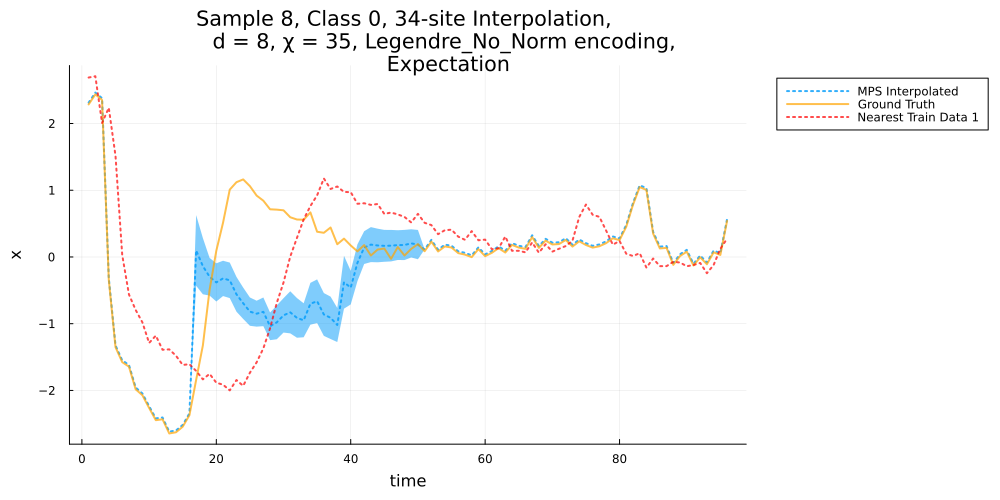

In [31]:
plot(p1...)


In [41]:
@profilehtml any_interpolate_single_timeseries(fc_ns, class, instance_idx, interp_sites, :directMode; NN_baseline=true, X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc);



┌ Info: Wrote profiling output to file:///home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/Interp_benchmarks/statprof/index.html .
└ @ StatProfilerHTML /home/noodles/.julia/packages/StatProfilerHTML/WyFko/src/StatProfilerHTML.jl:27


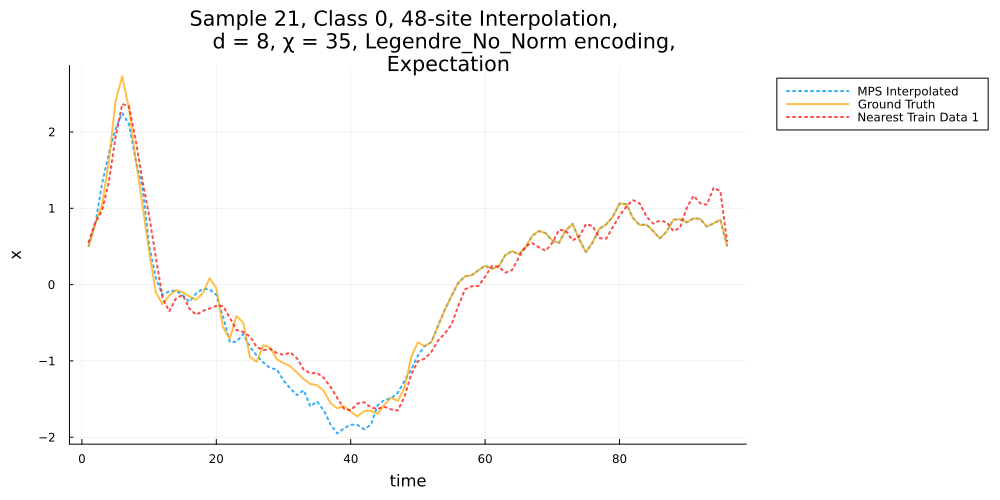

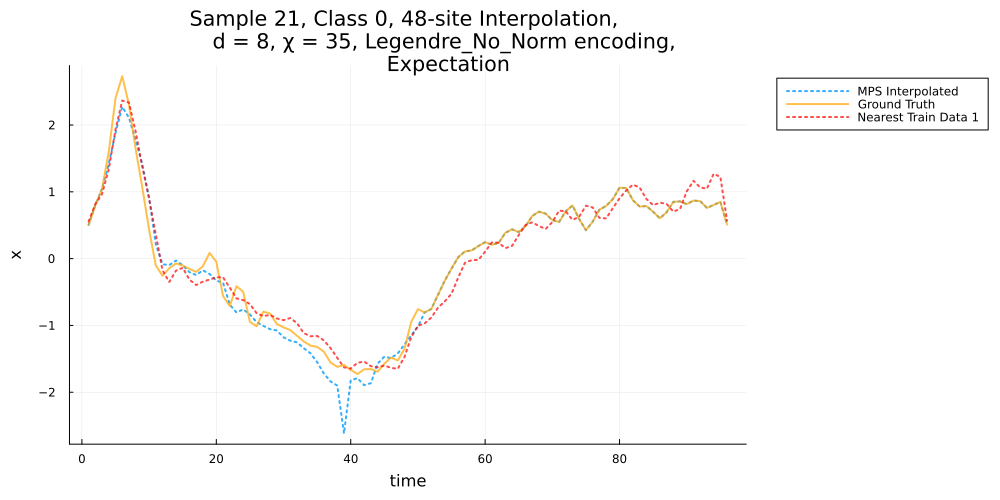

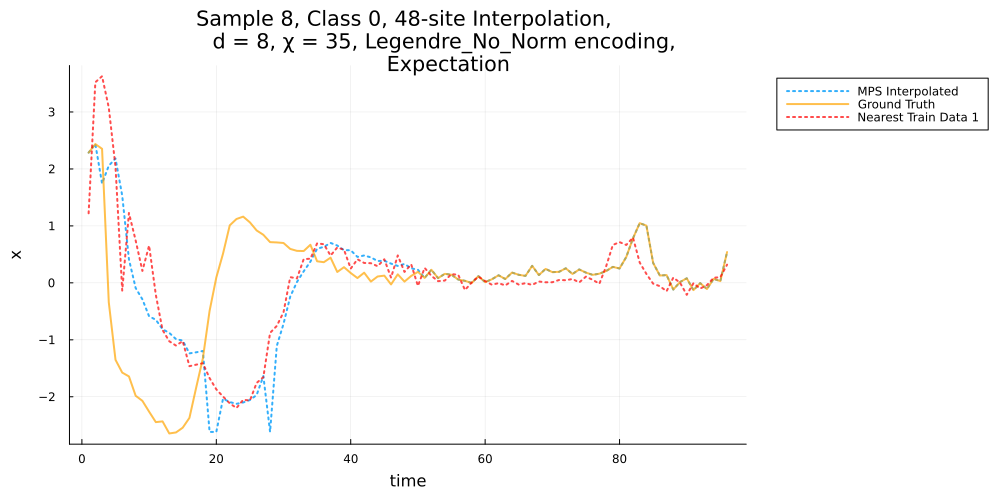

In [120]:
plot(p1...)

In [75]:
n1s = sum(y_test)
n0s = length(y_test) - n1s

n_each = 6
samples = [shuffle(1:n0s)[1:n_each]; shuffle(1:n1s)[1:n_each]]
interp_sites = collect(10:40)


31-element Vector{Int64}:
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
  ⋮
 32
 33
 34
 35
 36
 37
 38
 39
 40

In [60]:
include("../ForecastingMainNew.jl");





classes = [zeros(Int,n_each); ones(Int,n_each)]

ps = []
stats = []
for (i,s) in enumerate(samples)
    class = classes[i]
    instance_idx = s
    stat, p1 = any_interpolate_single_timeseries(fc_ns, class, instance_idx, interp_sites, :directMode; NN_baseline=true, X_train=X_train, y_train=y_train);
    push!(ps, p1...)
    push!(stats, stat)
end



In [61]:
stats_df = vcat(DataFrame.(stats)...)
@show describe(stats_df);


describe(stats_df) = 2×7 DataFrame
 Row │ variable  mean      min       median    max       nmissing  eltype
     │ Symbol    Float64   Float64   Float64   Float64   Int64     DataType
─────┼──────────────────────────────────────────────────────────────────────
   1 │ MAE       0.209845  0.125534  0.173989  0.367054         0  Float64
   2 │ NN_MAE    0.211525  0.121193  0.200798  0.330975         0  Float64


In [29]:
stats_df = vcat(DataFrame.(stats)...)
@show describe(stats_df);


describe(stats_df) = 2×7 DataFrame
 Row │ variable  mean      min       median   max      nmissing  eltype
     │ Symbol    Float64   Float64   Float64  Float64  Int64     DataType
─────┼────────────────────────────────────────────────────────────────────
   1 │ MAE       0.502225  0.161196  0.32344  1.28575         0  Float64
   2 │ NN_MAE    0.393543  0.194824  0.28402  1.10236         0  Float64


In [13]:
stats_df = vcat(DataFrame.(stats)...)
@show describe(stats_df);



describe(stats_df) = 2×7 DataFrame
 Row │ variable  mean     min       median    max      nmissing  eltype
     │ Symbol    Float64  Float64   Float64   Float64  Int64     DataType
─────┼────────────────────────────────────────────────────────────────────
   1 │ MAE       0.56956  0.242094  0.404932  1.67703         0  Float64
   2 │ NN_MAE    0.51692  0.213798  0.349041  1.58022         0  Float64


In [130]:
stats_df = vcat(DataFrame.(stats)...)
@show describe(stats_df);


describe(stats_df) = 2×7 DataFrame
 Row │ variable  mean      min       median    max       nmissing  eltype
     │ Symbol    Float64   Float64   Float64   Float64   Int64     DataType
─────┼──────────────────────────────────────────────────────────────────────
   1 │ MAE       0.459063  0.111677  0.32162   1.83016          0  Float64
   2 │ NN_MAE    0.306942  0.166638  0.277386  0.533318         0  Float64


12

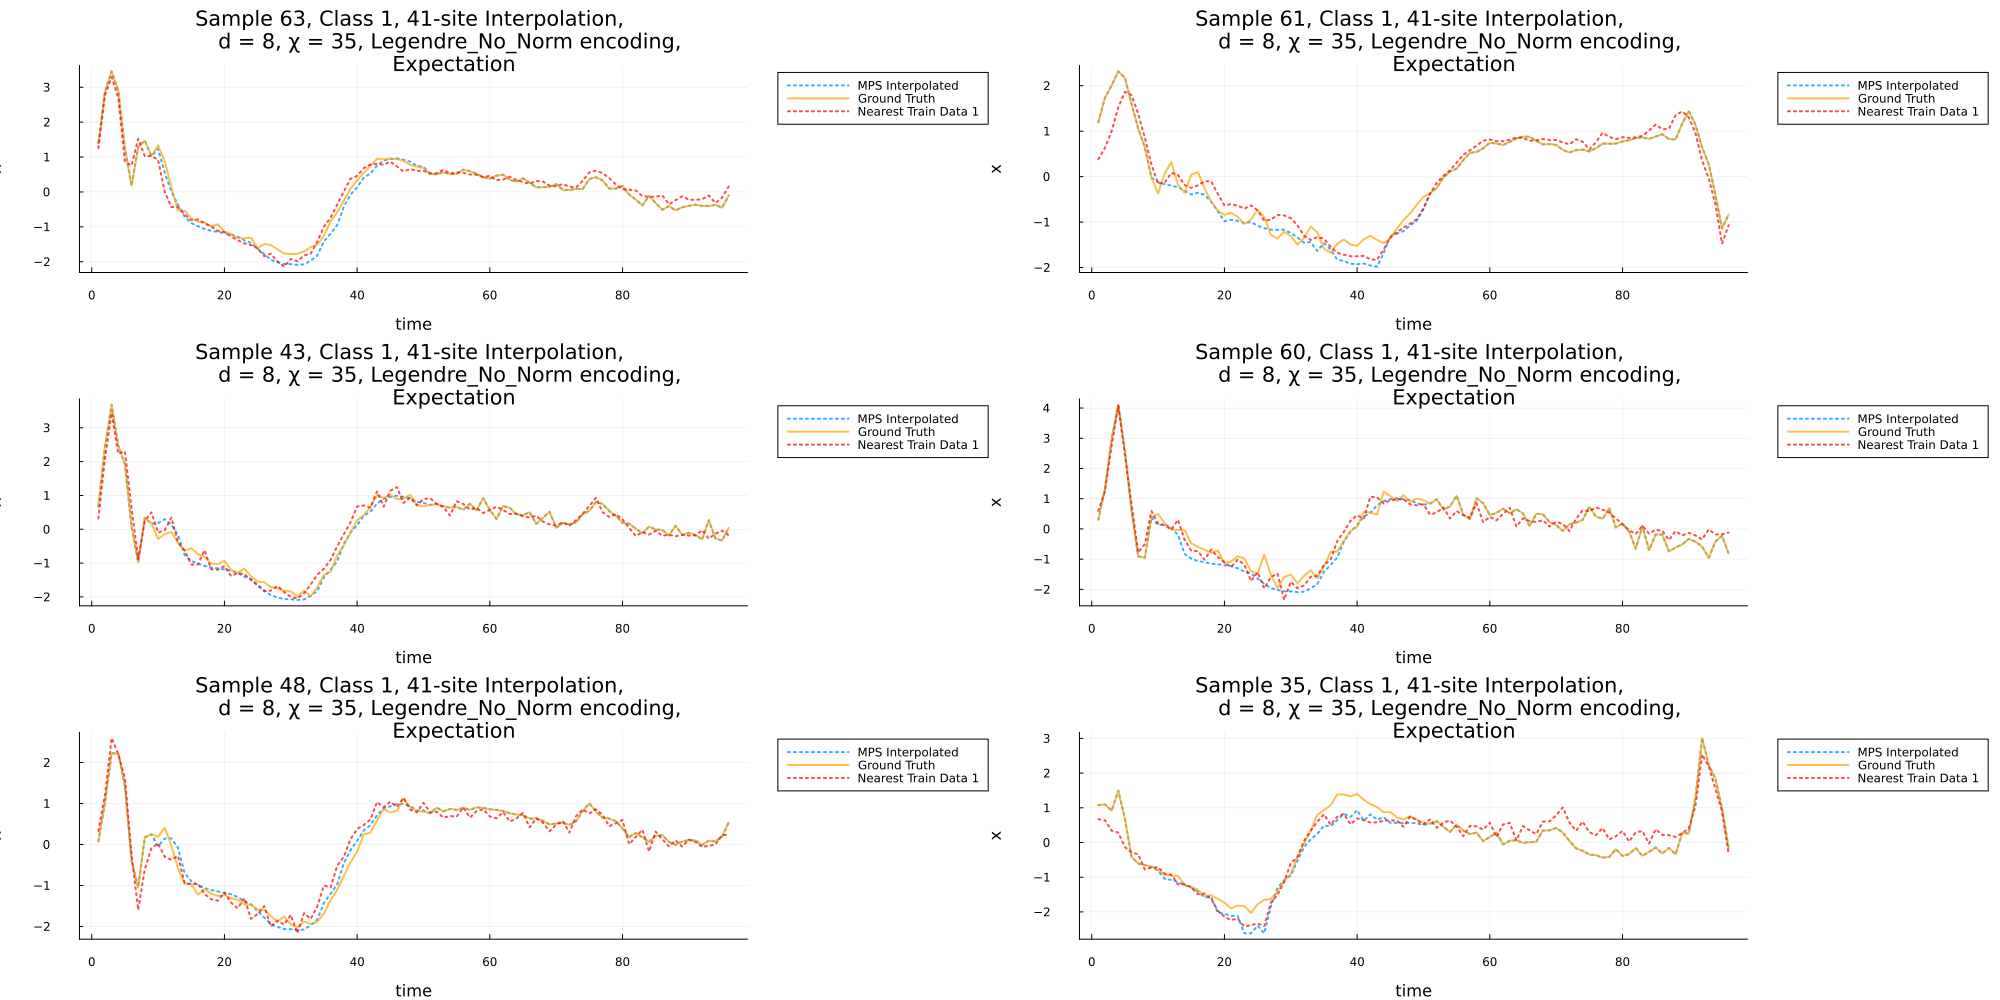

In [62]:

p1 = plot(ps[1:6]..., size=(2000,1000), layout=(3,2))
# savefig(p1, "figs/c0ecg.svg")

p2 = plot(ps[7:12]..., size=(2000,1000), layout=(3,2))
# savefig(p2, "figs/c1ecg.svg")


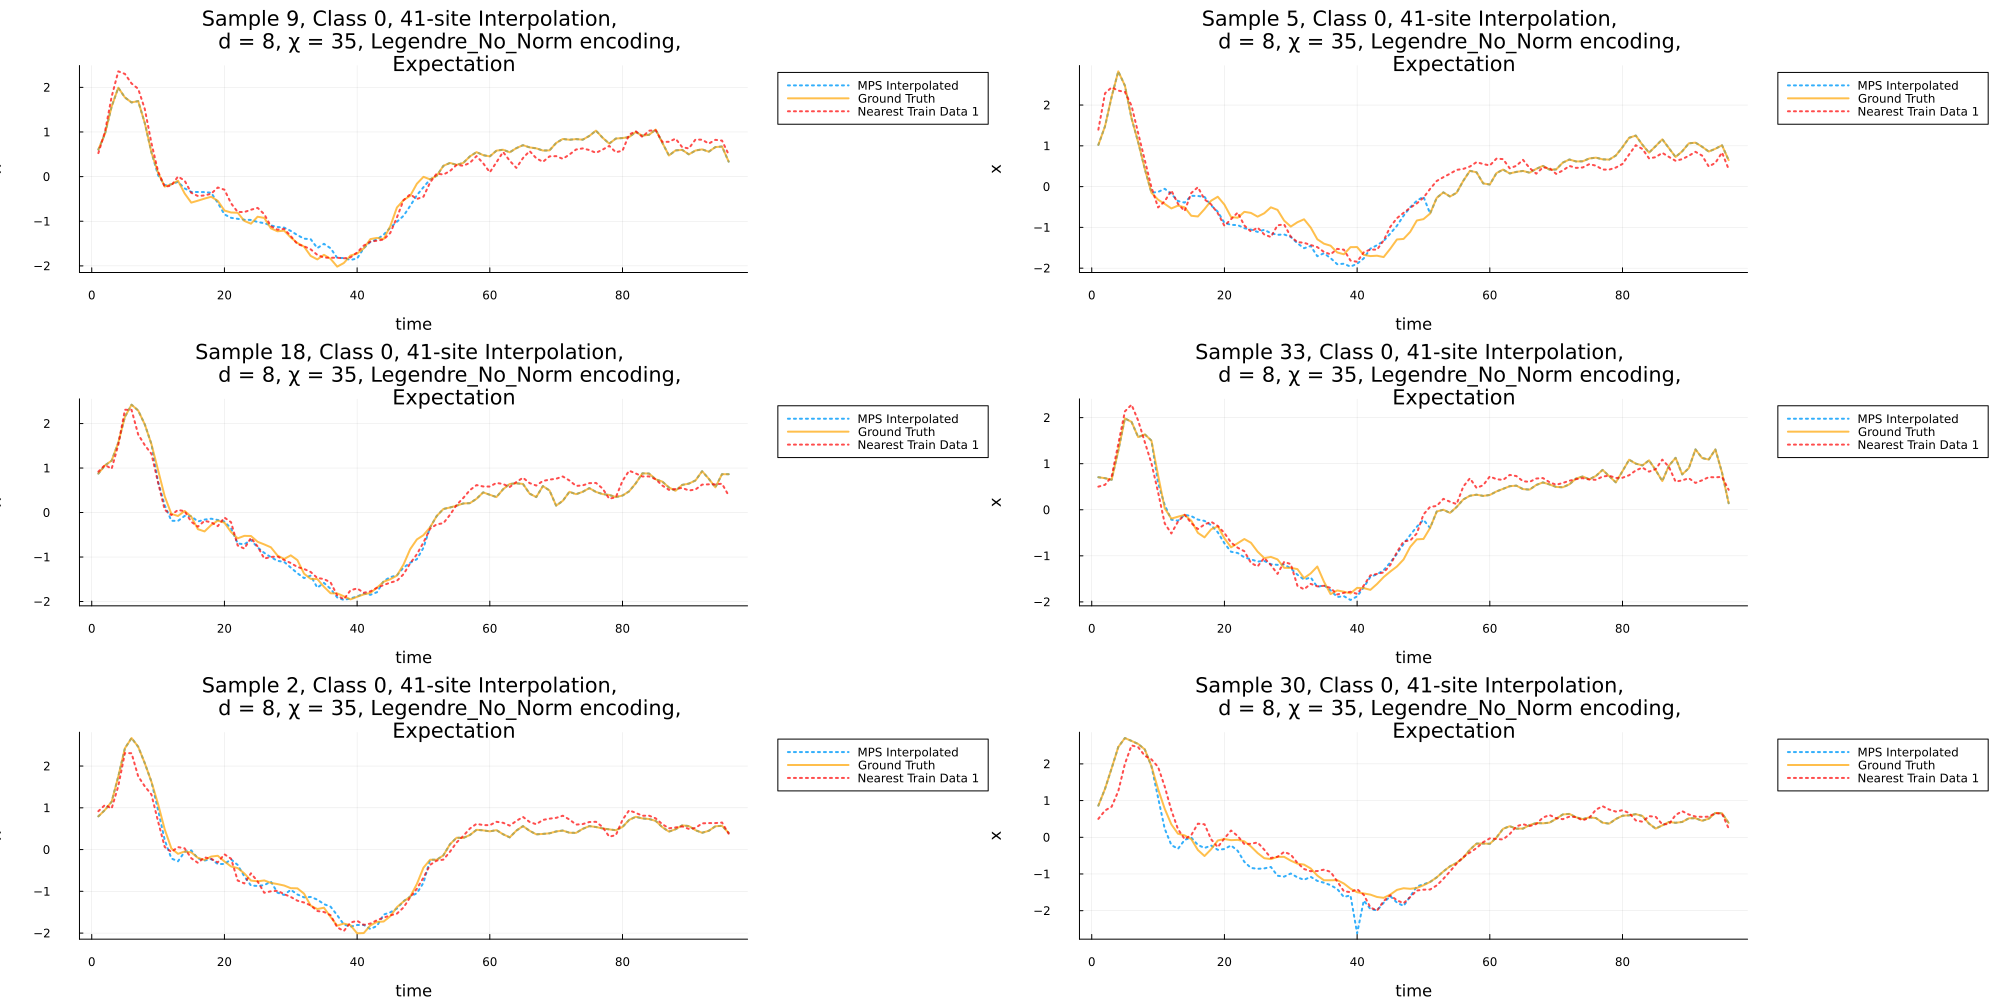

In [63]:
p1

In [135]:
p1

1-element Vector{Plots.Plot{Plots.GRBackend}}:
 Plot{Plots.GRBackend() n=3}

In [8]:
n1s = sum(y_test)
n0s = length(y_test) - n1s

samples = [shuffle(1:n0s); shuffle(1:n1s)]
te_classes = [zeros(Int,n0s); ones(Int,n1s)]

interp_sites = collect(10:40)

mode_range=opts.encoding.range
xvals=collect(range(mode_range...; step=1E-4))
mode_index=Index(opts.d)
xvals_enc= [get_state(x, opts) for x in xvals]
xvals_enc_it=[ITensor(s, mode_index) for s in xvals_enc];
include("../ForecastingMainNew.jl");


In [9]:


ps_ns = []
stats_ns = []
perc = 0.0
tstart = time()
for (i,s) in enumerate(samples)
    class = te_classes[i]
    instance_idx = s
    stat, p1 = any_interpolate_single_timeseries(fc_ns, class, instance_idx, interp_sites, :directMode; NN_baseline=true, X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc, xvals_enc_it=xvals_enc_it);
    push!(ps_ns, p1...)
    push!(stats_ns, stat)
    println("t=$(time() - tstart): $(i/length(samples) *100)% done")
end

which_sample = 9
target_timeseries_full = [-0.0541896224201347, 0.04998035083302632, 0.22840289396645796, 0.3523557984627921, 0.28835768335096357, 0.25553348841702617, 0.2644649066112583, 0.1192347717855653, -0.07357246091530789, -0.20707888854094958, -0.2977614620324064, -0.28279265371877016, -0.25907244752831804, -0.3426542491149367, -0.4031681730881307, -0.39038270139772646, -0.3766274834975093, -0.36446249621955085, -0.39150287189442934, -0.4551381636380162, -0.46797383544007887, -0.46966085436576155, -0.5233034044252182, -0.5416336924934344, -0.49585707066694873, -0.5034880509929149, -0.5722754193080299, -0.5915784464035174, -0.5874975930925774, -0.6323889160418611, -0.668419738834132, -0.6923237533099792, -0.7536159506607636, -0.7764032921285454, -0.7463230120008313, -0.772525187529722, -0.8240539340915578, -0.8000539147262684, -0.7511500157819775, -0.7380878639858358, -0.7039053700461078, -0.6429456101639603, -0.6350286984053493, -0.6427976124065194, -0.5579376230823688, -0.4352

DomainError: DomainError with -1.0155986526159755:
Legendre Polynomials are defined for arguments lying in -1 ⩽ x ⩽ 1

(-1, 1)

In [69]:
p1_ns = plot(ps_ns[1:6]..., size=(2000,1000), layout=(3,2))
savefig(p1_ns, "figs/c0ecg_ns.svg")

p2_ns = plot(ps_ns[7:12]..., size=(2000,1000), layout=(3,2))
savefig(p2_ns, "figs/c1ecg_ns.svg")

"/home/noodles/Documents/QML Project/QuantumInspiredML/Interpolation/Interp_benchmarks/figs/c1ecg_ns.svg"

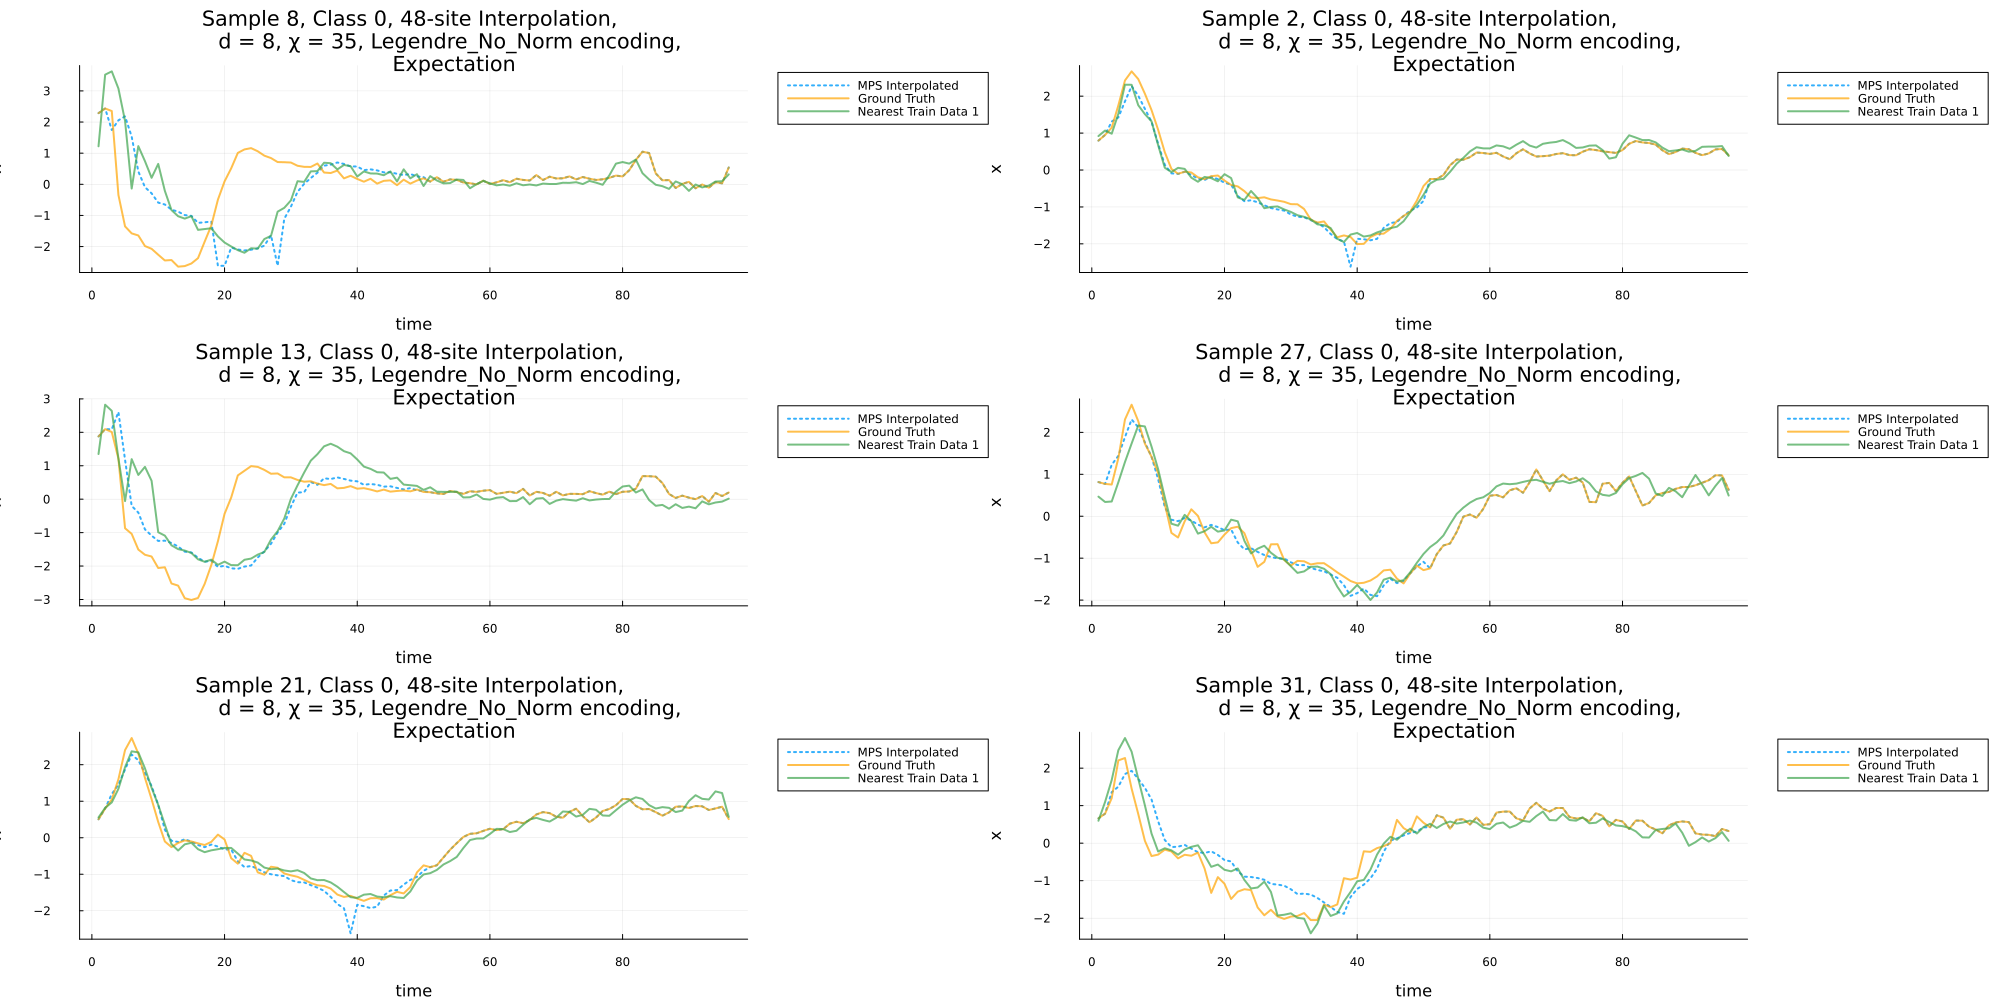

In [70]:
plot(p1_ns)

In [84]:
n1s = sum(y_test)
n0s = length(y_test) - n1s


samples = [shuffle(1:n0s); shuffle(1:n1s)]
classes = [zeros(Int,n0s); ones(Int,n1s)]

# ps = []
ps_ns = Vector{Any}(undef, length(samples))
# stats = []
stats_ns = Vector{Any}(undef, length(samples))

Threads.@threads for i in eachindex(samples)
    class = classes[i]
    instance_idx = samples[i]
    # stat, p1 = any_interpolate_single_timeseries(fc, class, instance_idx, interp_sites, :directMode; NN_baseline=true, X_train=X_train, y_train=y_train);
    stat_ns, p1_ns = any_interpolate_single_timeseries(fc_ns, class, instance_idx, interp_sites, :directMode; NN_baseline=true, X_train=X_train, y_train=y_train);

    # push!(ps, p1...)
    ps_ns[i] = p1_ns[:]   # push!(stats, stat)
    stats_ns[i] =  stat_ns
end


In [77]:
# Mode 10:40
stats_df = vcat(DataFrame.(stats)...)
stats_df_ns = vcat(DataFrame.(stats_ns)...)


@show describe(stats_df);
@show describe(stats_df_ns);



describe(stats_df) = 2×7 DataFrame
 Row │ variable  mean      min        median    max      nmissing  eltype
     │ Symbol    Float64   Float64    Float64   Float64  Int64     DataType
─────┼──────────────────────────────────────────────────────────────────────
   1 │ MAE       0.381493  0.143444   0.248384  1.77649         0  Float64
   2 │ NN_MAE    0.303991  0.0742772  0.231897  1.49337         0  Float64
describe(stats_df_ns) = 2×7 DataFrame
 Row │ variable  mean      min        median    max      nmissing  eltype
     │ Symbol    Float64   Float64    Float64   Float64  Int64     DataType
─────┼──────────────────────────────────────────────────────────────────────
   1 │ MAE       0.317432  0.102902   0.214053  1.47133         0  Float64
   2 │ NN_MAE    0.303991  0.0742772  0.231897  1.49337         0  Float64


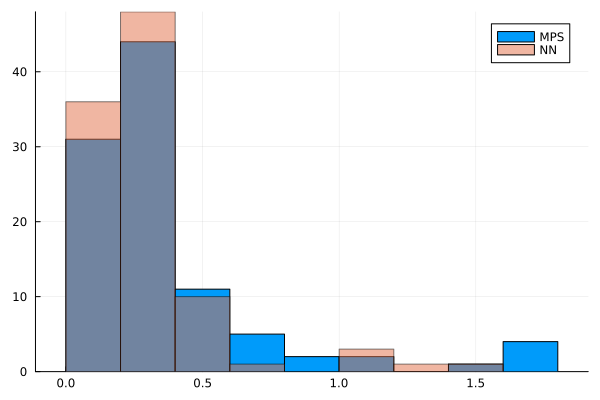

In [78]:
nbins=10
histogram(stats_df[!, :MAE], label="MPS", bins=nbins)
# vline!([median(stats_df[!, :MAE])], color=:blue, label="MPS Median")

histogram!(stats_df[!, :NN_MAE], label="NN", bins=nbins, alpha=0.5)

# vline!([median(stats_df[!, :NN_MAE])], color=:red, label="NN Median")

In [72]:
# Mode 10:50
stats_df = vcat(DataFrame.(stats)...)
stats_df_ns = vcat(DataFrame.(stats_ns)...)


@show describe(stats_df);
@show describe(stats_df_ns);



describe(stats_df) = 2×7 DataFrame
 Row │ variable  mean      min        median    max      nmissing  eltype
     │ Symbol    Float64   Float64    Float64   Float64  Int64     DataType
─────┼──────────────────────────────────────────────────────────────────────
   1 │ MAE       0.403777  0.130537   0.26017   1.45755         0  Float64
   2 │ NN_MAE    0.294078  0.0722684  0.228086  1.11456         0  Float64
describe(stats_df_ns) = 2×7 DataFrame
 Row │ variable  mean      min        median    max      nmissing  eltype
     │ Symbol    Float64   Float64    Float64   Float64  Int64     DataType
─────┼──────────────────────────────────────────────────────────────────────
   1 │ MAE       0.305869  0.113775   0.216956  1.14738         0  Float64
   2 │ NN_MAE    0.294078  0.0722684  0.228086  1.11456         0  Float64


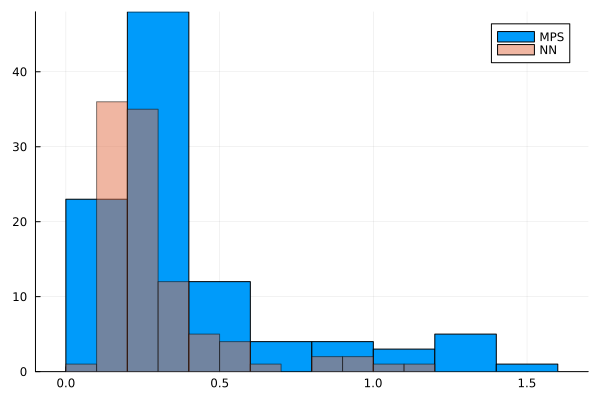

In [71]:
nbins=10
histogram(stats_df[!, :MAE], label="MPS", bins=nbins)
# vline!([median(stats_df[!, :MAE])], color=:blue, label="MPS Median")

histogram!(stats_df[!, :NN_MAE], label="NN", bins=nbins, alpha=0.5)

# vline!([median(stats_df[!, :NN_MAE])], color=:red, label="NN Median")

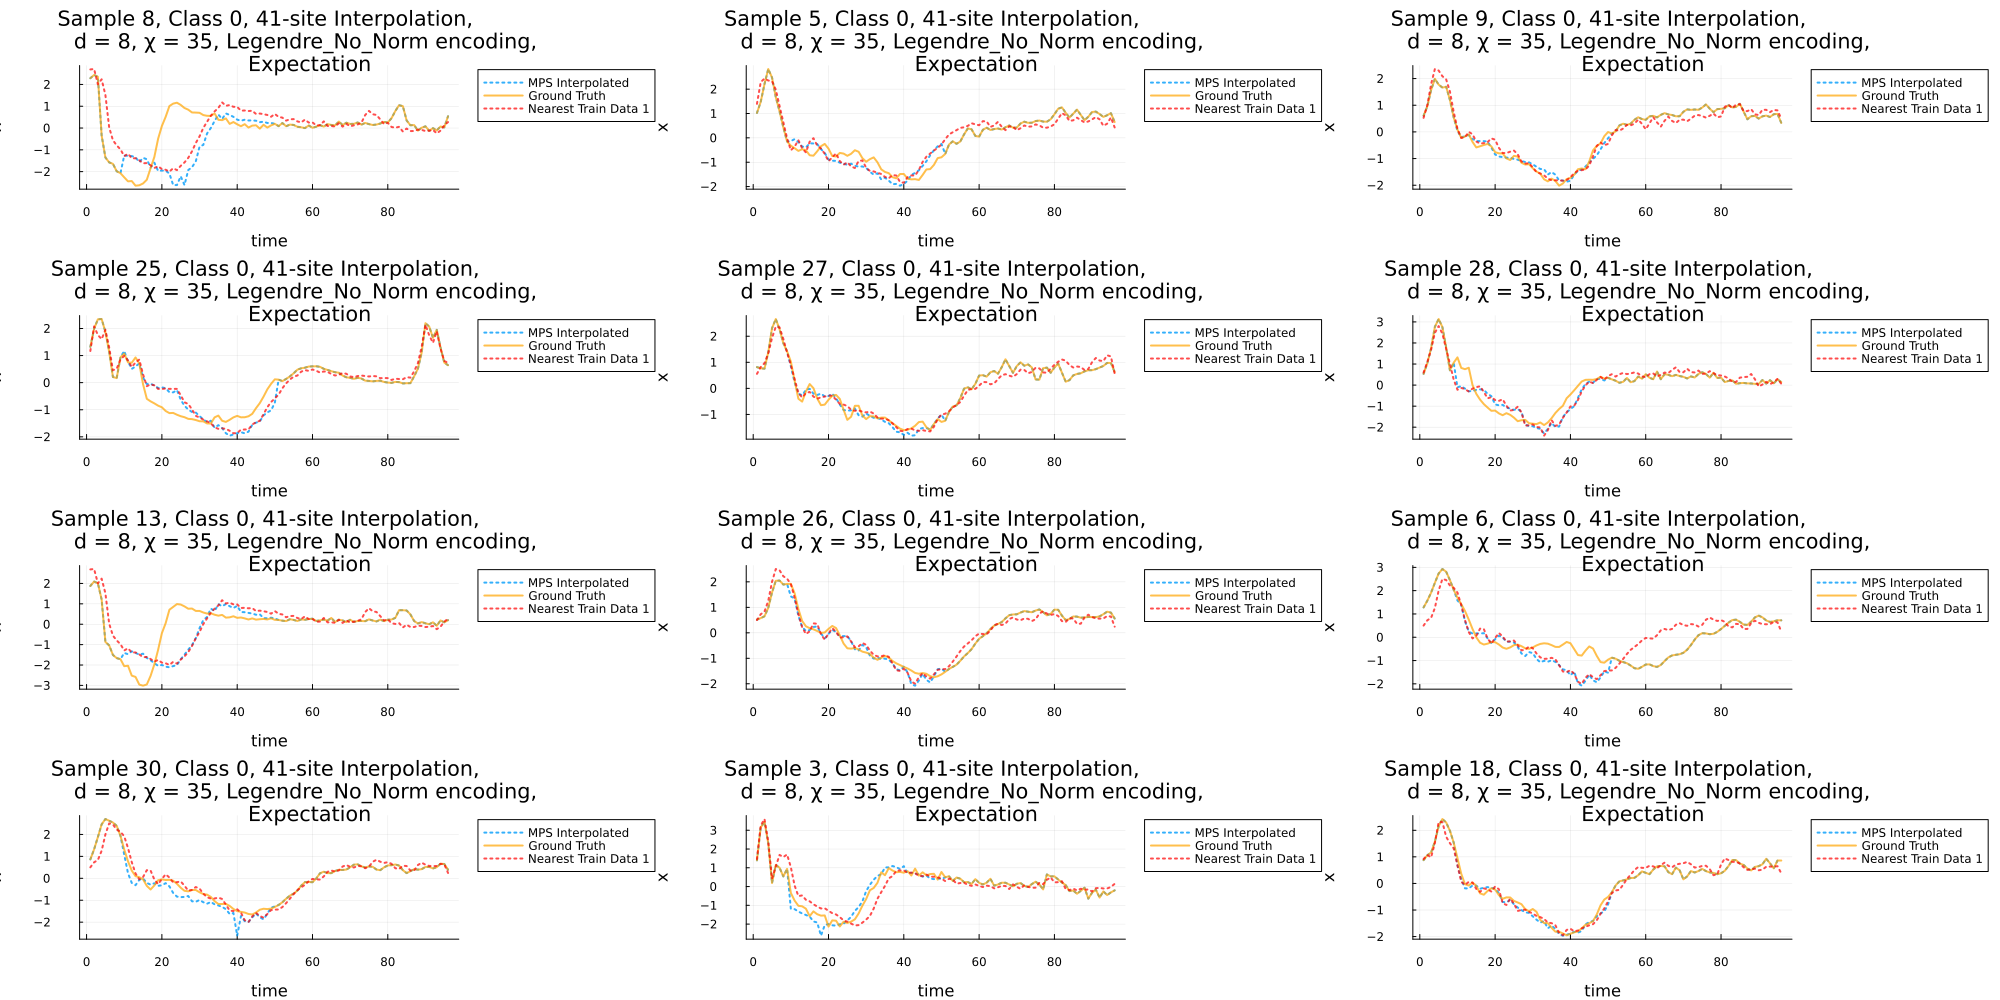

In [74]:
p1_ns = plot(ps_ns[1:12]..., size=(2000,1000), layout=(4,3))


# IPD

In [ ]:
svpath = "../../Data/italypower/mps_saves/legendreNN2_d12_chi60.jld2"
svpath = "../../Data/italypower/mps_saves/legendreNN2_ns_d12_chi60.jld2"

dloc =  "../../Data/ecg200/datasets/ecg200.jld2"



f = jldopen(dloc, "r")
    X_train = read(f, "X_train")
    y_train = read(f, "y_train")
    X_test = read(f, "X_test")
    y_test = read(f, "y_test")
close(f)



f = jldopen(svpath, "r")
    mps = read(f, "mps")
    opts = read(f, "opts")
close(f)
fc = load_forecasting_info_variables(mps, X_train, y_train, X_test, y_test, opts);


f = jldopen(svpath_ns, "r")
    mps_ns = read(f, "mps")
    opts_ns = read(f, "opts")
close(f)
fc_ns = load_forecasting_info_variables(mps_ns, X_train, y_train, X_test, y_test, opts_ns);

In [ ]:
class = 0
interp_sites = collect(5:24)
instance_idx = 2
stats, NN_stats, p1 = any_interpolate_single_time_series(fc, class, instance_idx, interp_sites, :directMean; NN_baseline=true, X_train_scaled=X_train_scaled, y_train=y_train);

plot(p1)

In [ ]:
n1s = sum(y_test)
n0s = length(y_test) - n1s
interp_sites = collect(5:24)


n_each = 6


samples = [shuffle(1:n0s)[1:n_each]; shuffle(1:n1s)[1:n_each]]
classes = [zeros(Int,n_each); ones(Int,n_each)]

ps = []
stats = []
NN_stats = []
for (i,s) in enumerate(samples)
    class = classes[i]
    instance_idx = s
    stat, NN_stat, p1 = any_interpolate_single_time_series(fc, class, instance_idx, interp_sites, :directMean; NN_baseline=true, X_train_scaled=X_train_scaled, y_train=y_train);
    push!(ps, p1)
    push!(stats, stat)
    push!(NN_stats, NN_stat)
end



In [ ]:
p1 = plot(ps[1:6]..., size=(2000,1000), layout=(3,2))
savefig(p1, "figs/c0IPD.svg")

p2 = plot(ps[7:12]..., size=(2000,1000), layout=(3,2))
savefig(p2, "figs/c1IPD.svg")

In [ ]:
@show p1

In [ ]:
n1s = sum(y_test)
n0s = length(y_test) - n1s


samples = [shuffle(1:n0s); shuffle(1:n1s)]
classes = [zeros(Int,n0s); ones(Int,n1s)]

ps = []
stats = []
NN_stats = []
for (i,s) in enumerate(samples)
    class = classes[i]
    instance_idx = s
    stat, NN_stat, p1 = any_interpolate_single_time_series(fc, class, instance_idx, interp_sites, :directMean; NN_baseline=true, X_train_scaled=X_train_scaled, y_train=y_train);
    push!(ps, p1)
    push!(stats, stat)
    push!(NN_stats, NN_stat)
end


In [ ]:
stats_df = vcat(DataFrame.(stats)...)
NN_stats_df = vcat(DataFrame.(NN_stats)...)

display(describe(stats_df));
println()
display(describe(NN_stats_df));

# Kepler

In [ ]:
include("../../Data/NASA_kepler/KeplerDataProcessor.jl")
all_kepler = load_dataset("../../Data/NASA_kepler/datasets/KeplerLightCurves.jld2"); 
w = 100
overlap_fraction = 0.0
window_single_instance(all_kepler, 125, w, overlap_fraction);

In [ ]:
discard = [18, 19, 33, 39] ####WHAT#### ?? THe same as 1212
X_train, X_test, y_train, y_test = make_train_test_split_singleTS(all_kepler, 125, discard, overlap_fraction; train_fraction=0.85, return_corrupted_windows=true);

In [ ]:
svpath = "../../Data/NASA_kepler/mps_saves/legendreNN2_d12_chi35.jld2"
f = jldopen(svpath, "r")
    X_train_scaled = read(f, "X_train_scaled")
    y_train = read(f, "y_train")
    X_test_scaled = read(f, "X_test_scaled")
    y_test = read(f, "y_test");
    mps = read(f, "mps")
    opts = read(f, "opts")
close(f)

fc = load_forecasting_info_variables(mps, X_train_scaled, y_train, X_test_scaled, y_test, opts);

In [ ]:
class = 0
interp_sites = collect(25:75)
instance_idx = 2
stats, NN_stats, p1 = any_interpolate_single_time_series(fc, class, instance_idx, interp_sites, :directMean; NN_baseline=true, X_train_scaled=X_train_scaled, y_train=y_train);

plot(p1)

In [ ]:
ns = length(y_test) 
interp_sites = collect(25:75)


samples = 1:ns
classes = zeros(Int,ns)

ps = []
stats = []
NN_stats = []
for (i,s) in enumerate(samples)
    class = classes[i]
    instance_idx = s
    stat, NN_stat, p1 = any_interpolate_single_time_series(fc, class, instance_idx, interp_sites, :directMean; NN_baseline=true, X_train_scaled=X_train_scaled, y_train=y_train);
    push!(ps, p1)
    push!(stats, stat)
    push!(NN_stats, NN_stat)
end

In [ ]:
stats_df = vcat(DataFrame.(stats)...)
NN_stats_df = vcat(DataFrame.(NN_stats)...)

display(describe(stats_df));
println()
display(describe(NN_stats_df));

In [ ]:
stats_df_tr = vcat(DataFrame.(stats[1:7])...)
NN_stats_df_tr = vcat(DataFrame.(NN_stats[1:7])...)

display(describe(stats_df_tr));
println()
display(describe(NN_stats_df_tr));

In [ ]:
p1 = plot(ps[1:6]..., size=(2000,1000), layout=(3,2))
savefig(p1, "figs/Keps125_1.svg")

p2 = plot(ps[7:11]..., size=(2000,1000), layout=(3,2))
savefig(p2, "figs/Keps125_2.svg")
display(p1)

In [ ]:
display(p2)

## Direct Mode

In [ ]:
ns = length(y_test) 


samples = 1:ns
classes = zeros(Int,ns)

ps = []
stats = []
NN_stats = []
for (i,s) in enumerate(samples)
    class = classes[i]
    instance_idx = s
    stat, NN_stat, p1 = any_interpolate_single_time_series(fc, class, instance_idx, interp_sites, :directMode; NN_baseline=true, X_train_scaled=X_train_scaled, y_train=y_train);
    push!(ps, p1)
    push!(stats, stat)
    push!(NN_stats, NN_stat)
end

In [ ]:
stats_df = vcat(DataFrame.(stats)...)
NN_stats_df = vcat(DataFrame.(NN_stats)...)

display(describe(stats_df));
println()
display(describe(NN_stats_df));

In [ ]:
p1 = plot(ps[1:6]..., size=(2000,1000), layout=(3,2))
savefig(p1, "figs/Keps125_1_mode.svg")

p2 = plot(ps[7:11]..., size=(2000,1000), layout=(3,2))
savefig(p2, "figs/Keps125_2_mode.svg")
display(p1)

In [ ]:
display(p2)

# Rand Kepler

In [ ]:
svpath = "../../Data/NASA_kepler/mps_saves/legendreNN2_d12_chi35.jld2"
f = jldopen(svpath, "r")
    X_train_scaled = read(f, "X_train_scaled")
    y_train = read(f, "y_train")
    X_test_scaled = read(f, "X_test_scaled")
    y_test = read(f, "y_test");
    mps = read(f, "mps")
    opts = read(f, "opts")
close(f)

fc = load_forecasting_info_variables(mps, X_train_scaled, y_train, X_test_scaled, y_test, opts);

In [ ]:
ns = length(y_test) 
interp_sites = shuffle(1:100)[1:90]


samples = 1:ns
classes = zeros(Int,ns)

ps = []
stats = []
NN_stats = []
for (i,s) in enumerate(samples)
    class = classes[i]
    instance_idx = s
    stat, NN_stat, p1 = any_interpolate_single_time_series(fc, class, instance_idx, interp_sites, :directMean; NN_baseline=true, X_train_scaled=X_train_scaled, y_train=y_train);
    push!(ps, p1)
    push!(stats, stat)
    push!(NN_stats, NN_stat)
end

In [ ]:
stats_df = vcat(DataFrame.(stats)...)
NN_stats_df = vcat(DataFrame.(NN_stats)...)

display(describe(stats_df));
println()
display(describe(NN_stats_df));

In [ ]:
p1 = plot(ps[1:6]..., size=(2000,1000), layout=(3,2))
savefig(p1, "figs/Keps125_1_rand.svg")

p2 = plot(ps[7:11]..., size=(2000,1000), layout=(3,2))
savefig(p2, "figs/Keps125_2_rand.svg")
display(p1)

In [ ]:
display(p2)

# Kepler 564

In [ ]:

f = jldopen("../../Data/NASA_kepler/mps_saves/legendreNN_s564_d12_chi34.jld2")
X_train_scaled = read(f, "X_train_scaled")
y_train = read(f, "y_train")
X_test_scaled = read(f, "X_test_scaled")
y_test = read(f, "y_test");
mps = read(f, "mps")
opts = read(f, "opts")
close(f)

fc = load_forecasting_info_variables(mps, X_train_scaled, y_train, X_test_scaled, y_test, opts);

In [ ]:
class = 0
interp_sites = collect(25:75)
instance_idx = 2
stats, NN_stats, p1 = any_interpolate_single_time_series(fc, class, instance_idx, interp_sites, :directMean; NN_baseline=true, X_train_scaled=X_train_scaled, y_train=y_train);

plot(p1)

In [ ]:
ns = length(y_test) 


samples = 1:ns
classes = zeros(Int,ns)

ps = []
stats = []
NN_stats = []
for (i,s) in enumerate(samples)
    class = classes[i]
    instance_idx = s
    stat, NN_stat, p1 = any_interpolate_single_time_series(fc, class, instance_idx, interp_sites, :directMean; NN_baseline=true, X_train_scaled=X_train_scaled, y_train=y_train);
    push!(ps, p1)
    push!(stats, stat)
    push!(NN_stats, NN_stat)
end

In [ ]:
stats_df = vcat(DataFrame.(stats)...)
NN_stats_df = vcat(DataFrame.(NN_stats)...)

display(describe(stats_df));
println()
display(describe(NN_stats_df));

In [ ]:
stats_df_tr = vcat(DataFrame.(stats[1:22])...)
NN_stats_df_tr = vcat(DataFrame.(NN_stats[1:22])...)

display(describe(stats_df_tr));
println()
display(describe(NN_stats_df_tr));

In [ ]:
p1 = plot(ps[1:6]..., size=(2000,1000), layout=(3,2))
savefig(p1, "figs/Keps564_1.svg")

p2 = plot(ps[end-5:end]..., size=(2000,1000), layout=(3,2))
savefig(p2, "figs/Keps564_2.svg")
display(p1)

In [ ]:
display(p2)